In [39]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image
import math
from scipy.optimize import curve_fit


In [40]:
#Functions
def alpha(z):
    return np.sin(np.pi * z / 2)
def dBr_dz(B_r):
    return np.gradient(B_r, dz)
def d2Br_dz2(B_r):
    return np.gradient(np.gradient(B_r, dz), dz)
def d2Bphi_dz2(B_phi):
    return np.gradient(np.gradient(B_phi, dz), dz)
def dBrdt(B_r, B_phi):
    return - (h * alpha_0 / eta_t) * dBr_dz(B_phi * alpha(z)) + d2Br_dz2(B_r)
def dBphidt(B_r, B_phi):
    return - (h**2 * q * Omega / eta_t) * B_r + d2Bphi_dz2(B_phi)

def rk4_step(B_r, B_phi):
    k1_r = dt * dBrdt(B_r, B_phi)    
    k1_phi = dt * dBphidt(B_r, B_phi)    
    
    k2_r = dt * dBrdt(B_r + 0.5 * k1_r, B_phi + 0.5 * k1_phi)
    k2_phi = dt * dBphidt(B_r + 0.5 * k1_r, B_phi + 0.5 * k1_phi)
    
    k3_r = dt * dBrdt(B_r + 0.5 * k2_r, B_phi + 0.5 * k2_phi)
    k3_phi = dt * dBphidt(B_r + 0.5 * k2_r, B_phi + 0.5 * k2_phi)    
    
    k4_r = dt * dBrdt(B_r + k3_r, B_phi + k3_phi)    
    k4_phi = dt * dBphidt(B_r + k3_r, B_phi + k3_phi)
    
    B_r_new = B_r + (k1_r + 2 * k2_r + 2 * k3_r + k4_r) / 6
    B_phi_new = B_phi + (k1_phi + 2 * k2_phi + 2 * k3_phi + k4_phi) / 6
    
    B_r_new[0] = 0
    B_r_new[-1] = 0
    B_phi_new[0] = 0
    B_phi_new[-1] = 0
    
    return B_r_new, B_phi_new
def initial_condition(x):
    return np.sin(np.pi *((x+L)/(2*L)))
def update_plot1(frame):
    global B_r0, B_phi0,BrvT,BphivT
    B_r0, B_phi0 = rk4_step(B_r0, B_phi0)
    BrvT[frame,:]=B_r0.copy()
    BphivT[frame,:]=B_phi0.copy()
    line_br.set_ydata(B_r0)
    line_bphi.set_ydata(B_phi0)
    ax.set_title(f'Time = {(frame+1) * 100 * dt:.2f}')
    min_B = np.min([np.min(B_r0), np.min(B_phi0)])
    max_B = np.max([np.max(B_r0), np.max(B_phi0)])
    ax.set_ylim(1.1*min_B , 1.1*max_B)    
    return line_br, line_bphi

Dynamo Number: -0.1


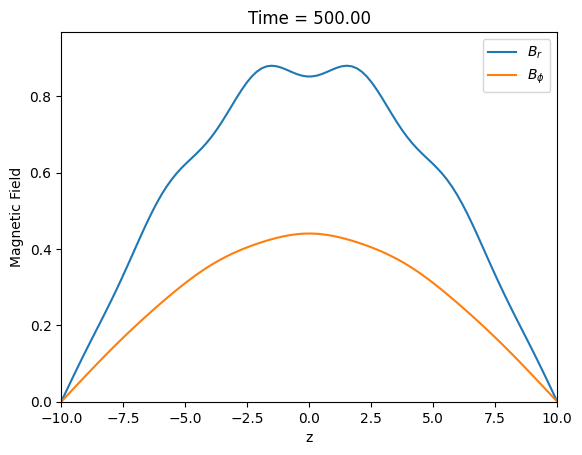

In [41]:
# Parameters
h = 1.0   
alpha_0 = 1.0  
q = 1.0   
Omega = 1.0  
eta_t = 10.0
t0=1.0
#grid parameters
L = 10.0  
N = 100   
dt = 0.01 
T = 500
max_frames = int(T / (100 * dt))
nt=int(T/dt)
Tlis = np.linspace(0, T, max_frames)
dynamo_number = - (q * Omega * alpha_0 * h**3) / eta_t
print("Dynamo Number:", dynamo_number)
BrvT =np.zeros((max_frames,N))
BphivT = np.zeros((max_frames,N))
dz = 2*L / (N - 1)
z = np.linspace(-L, L, N)

B_r0 = np.zeros(N)
B_phi0 = np.zeros(N)
B_r0=initial_condition(z)
B_phi0=initial_condition(z)
#changing to dimensionless units

Tlis=Tlis/t0
z=z/h
alpha_0=alpha_0*t0/h
Omega=Omega*t0

BrvT[0,:]=B_r0
BphivT[0,:]=B_phi0
fig, ax = plt.subplots()
ax.set_xlim(-L, L)
ax.set_xlabel('z')
ax.set_ylabel('Magnetic Field')
ax.set_title('Magnetic Field Evolution')

line_br, = ax.plot(z, B_r0, label='$B_r$')
line_bphi, = ax.plot(z, B_phi0, label='$B_{\phi}$')
ax.legend()
ani = FuncAnimation(fig, update_plot1, frames=max_frames, interval=200, blit=True)#this also doubles as the main loop
ani.save(f'magnetic_field_evolution(T={T}).gif', writer='pillow')
plt.show()


In [81]:
def onevarsum(a):#finds sum of 1 variable
    sum1=0
    for i in range(len(a)):
        sum1+=a[i]
    return sum1
def twovarsum(a,b):
    sum1=0
    for i in range(len(a)):
        sum1+=(a[i]*b[i])
    return sum1
def interceptandslope(x,y):#least square fit
    s=len(x)
    sx=onevarsum(x)
    sxx=twovarsum(x,x)
    sy=onevarsum(y)
    sxy=twovarsum(x,y)
    delt=(s*sxx-(sx**2))
    intercept=(sxx*sy-sx*sxy)/delt
    slop=(sxy*s-sx*sy)/delt
    errslope=(s/delt)**0.5
    errinter=(sxx/delt)**0.5
    return(slop,intercept)#,errinter,errslope
def get_gamma(BrvT,BphivT):
    b_fit=[]
    b_fit2=[]
    for i in range(0,len(BrvT)):
        B=BrvT[i]
        B2=BphivT[i]
        b_fit.append(B[index])
        b_fit2.append(B2[index])
    """def exponential_func(t, B0, gamma):
        return B0 * np.exp(gamma * t)
    Tlis = np.linspace(0, T, max_frames)
    popt, pcov = curve_fit(exponential_func, Tlis, b_fit)
    popt1, pcov1 = curve_fit(exponential_func, Tlis, b_fit2)    
    print("Gamma from fit for B_r:", popt[1])#global fit
    print("Gamma from fit for B_phi:", popt1[1])
    gamma=popt[1]"""
    log_B = np.log(b_fit)
    log_B2=np.log(b_fit2)
    slop1,_=interceptandslope(Tlis,log_B)
    slop2,_=interceptandslope(Tlis,log_B2)
    print("Gamma from linear fit for B_r:", slop1)#global fit
    print("Gamma from linear fit for B_phi:", slop2)
    plt.plot(Tlis,log_B,label=f"$B_r$ $\gamma$={slop1:.6f}")    
    plt.plot(Tlis,log_B2,label=f"$B_\phi$ $\gamma$={slop2:.6f}")
    
    plt.ylabel("log B")
    plt.xlabel("T")
    plt.title("log B vs T")
    plt.grid()
    plt.legend()
    plt.show()
    

Gamma from linear fit for B_r: -0.00023518106836322973
Gamma from linear fit for B_phi: -0.001609064495071738


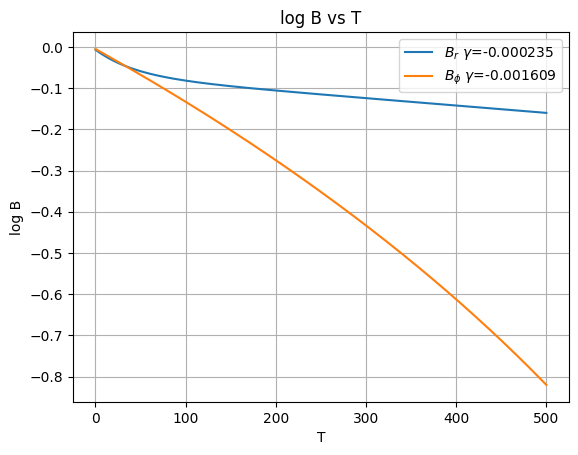

In [82]:
get_gamma(BrvT,BphivT)

Slope of the first segment: -0.0010347775320622195
Slope of the second segment: -0.0002008062948690564


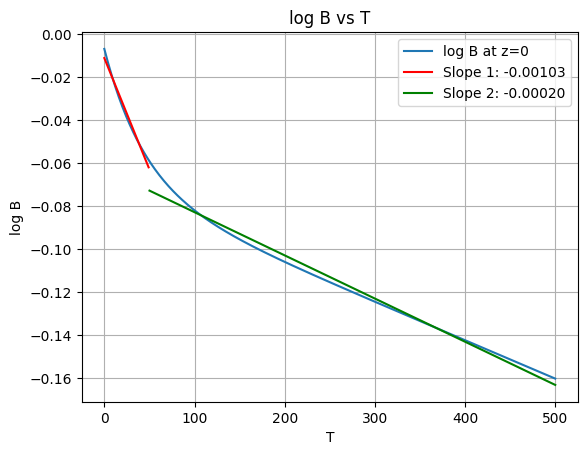

In [83]:
split_index=50

slope1, intercept1 = interceptandslope(Tlis[:split_index], log_B[:split_index])
slope2, intercept2 = interceptandslope(Tlis[split_index:], log_B[split_index:])
print("Slope of the first segment:", slope1)#these are local slopes in time
print("Slope of the second segment:", slope2)
plt.plot(Tlis, log_B, label="log B at z=0")
plt.plot(Tlis[:split_index], slope1 * Tlis[:split_index] + intercept1, color='red', label=f"Slope 1: {slope1:.5f}")
plt.plot(Tlis[split_index:], slope2 * Tlis[split_index:] + intercept2, color='green', label=f"Slope 2: {slope2:.5f}")

plt.ylabel("log B")
plt.xlabel("T")
plt.title("log B vs T")
plt.grid()
plt.legend()
plt.show()

In [84]:
def find_critical_dynamo_number(eta_t_values):
    critical_dynamo_numbers = []
    for eta_t in eta_t_values:
        B_r0 = initial_condition(z)
        B_phi0 = initial_condition(z)        
        
        for _ in range(max_frames):
            B_r0, B_phi0 = rk4_step(B_r0, B_phi0)
        
        magnetic_field_no_z = np.sqrt(B_r0 ** 2 + B_phi0 ** 2)#if this value decreases we can say that the dynamo is decaying and thus is not growing
        m_e.append(magnetic_field_no_z)
        if magnetic_energy > 1e-6:  # Adjust the threshold as needed
            # If magnetic energy grows, append the eta_t value to the critical_dynamo_numbers list
            critical_dynamo_numbers.append(eta_t)
        else:
            # If magnetic energy does not grow, break the loop
            break
    
    # Return the critical dynamo number
    if critical_dynamo_numbers:
        return max(critical_dynamo_numbers)
    else:
        return None

# Define a range of eta_t values to iterate over
eta_t_values = np.linspace(0.01, 10.0, 100)
print(eta_t_values)
# Find the critical dynamo number
critical_dynamo_number = find_critical_dynamo_number(eta_t_values)

# Print the critical dynamo number
if critical_dynamo_number is not None:
    print("Critical dynamo number:", critical_dynamo_number)
else:
    print("Dynamo action is not present in the given range of eta_t values.")


[ 0.01        0.11090909  0.21181818  0.31272727  0.41363636  0.51454545
  0.61545455  0.71636364  0.81727273  0.91818182  1.01909091  1.12
  1.22090909  1.32181818  1.42272727  1.52363636  1.62454545  1.72545455
  1.82636364  1.92727273  2.02818182  2.12909091  2.23        2.33090909
  2.43181818  2.53272727  2.63363636  2.73454545  2.83545455  2.93636364
  3.03727273  3.13818182  3.23909091  3.34        3.44090909  3.54181818
  3.64272727  3.74363636  3.84454545  3.94545455  4.04636364  4.14727273
  4.24818182  4.34909091  4.45        4.55090909  4.65181818  4.75272727
  4.85363636  4.95454545  5.05545455  5.15636364  5.25727273  5.35818182
  5.45909091  5.56        5.66090909  5.76181818  5.86272727  5.96363636
  6.06454545  6.16545455  6.26636364  6.36727273  6.46818182  6.56909091
  6.67        6.77090909  6.87181818  6.97272727  7.07363636  7.17454545
  7.27545455  7.37636364  7.47727273  7.57818182  7.67909091  7.78
  7.88090909  7.98181818  8.08272727  8.18363636  8.28454545  8

NameError: name 'm_e' is not defined